In [145]:
# --- podstawy ---
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# --- sklearn: przygotowanie, modele, metryki, pipeline ---
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- xgboost (boosting drzew) ---
import xgboost as xgb
import shap 
# --- wizualizacje ---
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,5)

DATA_PATH = Path("../data/processed/epl_features.csv")
RANDOM_STATE = 42


In [146]:
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.sort_values(["Date", "HomeTeam", "AwayTeam"]).reset_index(drop=True)
print(df.shape)
df.head(3)


(3420, 100)


,Div,Date,HomeTeam,AwayTeam,Referee,FTHG,FTAG,FTR,HS,AS,...,IsHomeAlways1,Month,Weekday,IsWeekend,Home_AvgPts_season,Home_AvgGD_season,Away_AvgPts_season,Away_AvgGD_season,SeasonStrength_PtsDiff,SeasonStrength_GDDiff
0,E0,2014-08-16,Arsenal,Crystal Palace,J Moss,2.0,1.0,H,14.0,4.0,...,1,8,5,1,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2014-08-16,Leicester,Everton,M Jones,2.0,2.0,D,11.0,13.0,...,1,8,5,1,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2014-08-16,Manchester United,Swansea,M Dean,1.0,2.0,A,14.0,5.0,...,1,8,5,1,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
target = "FTR"

cols_to_exclude = {
    # meta / identyfikatory
    "Div", "Date", "Season", "SourceFile", "HomeTeam", "AwayTeam", "Referee",

    # wynikowe i bieżące statystyki meczu (niedostępne przed meczem)
    "FTHG", "FTAG", "HTHG", "HTAG", "FTR",
    "GoalDiff", "TotalGoals",
    "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC",
    "HY", "AY", "HR", "AR",

    # NOWE — usuwamy nadmiarowe prawdopodobieństwa, które psują regresję
    "Prob_D_b365", "Prob_A_b365"

    # jeśli masz inne pary typu Prob_D_ps / Prob_A_ps itp. — też dodaj je tutaj
}

# kandydaci na cechy:
candidate_cols = [
    c for c in df.columns
    if c not in cols_to_exclude
]

# wzorce cech predykcyjnych (rynek, forma, sezon, czas)
keep_patterns = (
    "Prob_", "Margin_", "OddsDiff", "OddsSpread",
    "Home_", "Away_", "FormDiff_", "Pts_trend_3v10",
    "SeasonStrength_", "Month", "Weekday", "IsWeekend"
)

X_features = [c for c in candidate_cols if any(p in c for p in keep_patterns)]

# sanity check
print(f"Liczba wybranych cech: {len(X_features)}")
X_features[:10]


Liczba wybranych cech: 56


['Prob_H_b365',
 'Margin_B365',
 'OddsDiff_B365',
 'Prob_H_ps',
 'Prob_D_ps',
 'Prob_A_ps',
 'Margin_PS',
 'OddsDiff_PS',
 'OddsSpread_H',
 'OddsSpread_D']

In [148]:
# label encoding dla y (H/D/A -> 0/1/2)
le = LabelEncoder()
y = le.fit_transform(df[target])

# split po dacie (przykład: uczymy na meczach przed 2020-01-01, testujemy na 2020+)
split_date = pd.Timestamp("2022-07-01")
train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X = df[X_features].copy()

X_train = X.loc[train_mask].reset_index(drop=True)
X_test  = X.loc[test_mask].reset_index(drop=True)
y_train = y[train_mask]
y_test  = y[test_mask]

X_train.shape, X_test.shape, len(y_train), len(y_test)


((2660, 56), (760, 56), 2660, 760)

Liczba cech: 56

=== CROSS-VALIDATION (RMSE) ===
Linear Regression: RMSE mean=0.9282 | std=0.1161
Ridge Regression: RMSE mean=0.7835 | std=0.0233
Lasso Regression: RMSE mean=0.7800 | std=0.0238
ElasticNet Regression: RMSE mean=0.7808 | std=0.0236

==================== Linear Regression ====================
RMSE: 0.7808
R²:   0.1869
Accuracy (po mapowaniu): 0.3645
Macro-F1 (po mapowaniu): 0.3519


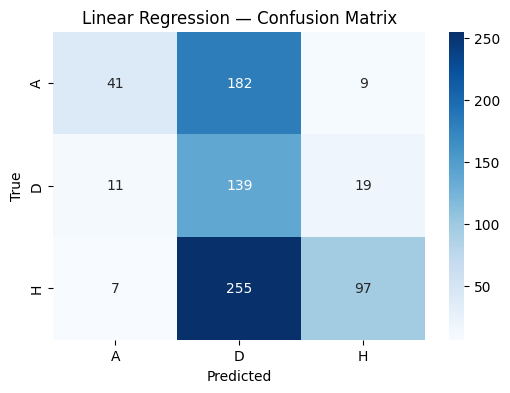


==================== Ridge Regression ====================
RMSE: 0.7802
R²:   0.1881
Accuracy (po mapowaniu): 0.3632
Macro-F1 (po mapowaniu): 0.3521


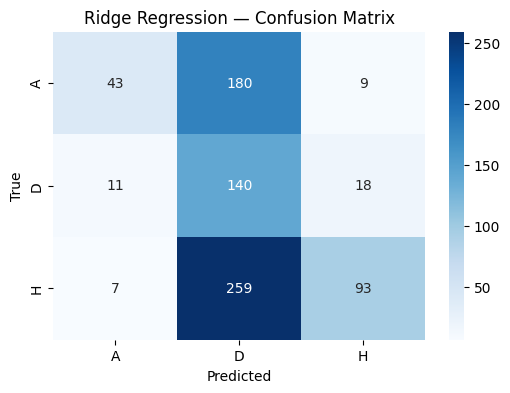


==================== Lasso Regression ====================
RMSE: 0.7786
R²:   0.1914
Accuracy (po mapowaniu): 0.3645
Macro-F1 (po mapowaniu): 0.3543


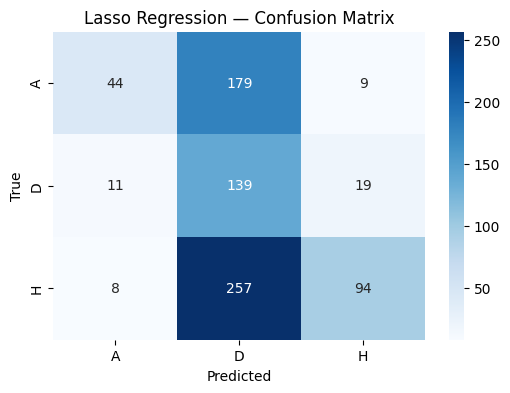


==================== ElasticNet Regression ====================
RMSE: 0.7795
R²:   0.1895
Accuracy (po mapowaniu): 0.3697
Macro-F1 (po mapowaniu): 0.3599


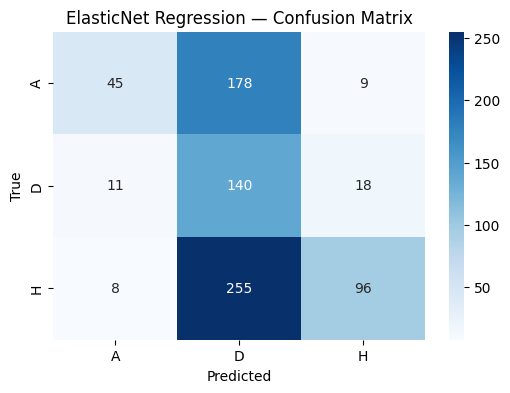


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA A) ===


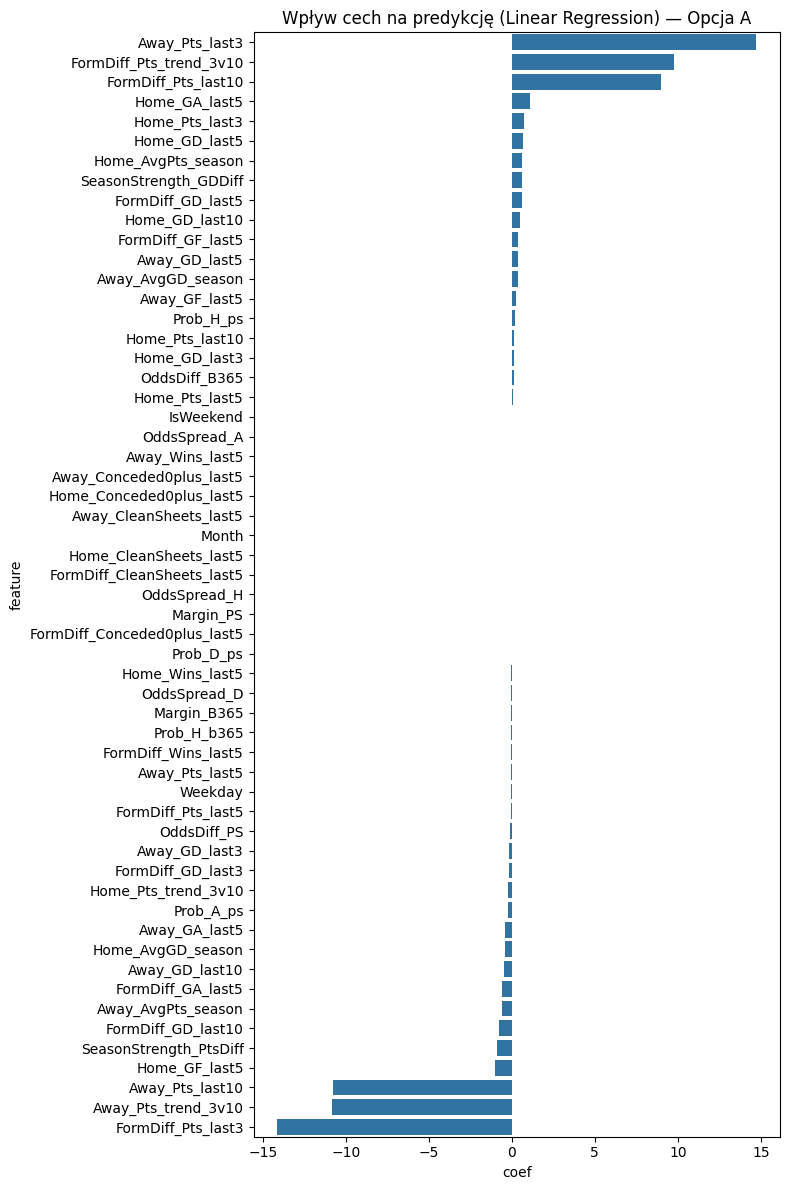

,feature,coef
30,Away_Pts_last3,14.713816
46,FormDiff_Pts_trend_3v10,9.797937
44,FormDiff_Pts_last10,8.980795
12,Home_GA_last5,1.092842
18,Home_Pts_last3,0.743953
13,Home_GD_last5,0.672845
50,Home_AvgPts_season,0.623882
55,SeasonStrength_GDDiff,0.602359
37,FormDiff_GD_last5,0.597688
21,Home_GD_last10,0.516454


In [149]:
# ============================================
# 1. Importy
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler





# ============================================
# 2. Selekcja cech
# ============================================

target = "FTR"

cols_to_exclude = {
    # meta / identyfikatory
    "Div", "Date", "Season", "SourceFile", "HomeTeam", "AwayTeam", "Referee",

    # wynikowe i bieżące statystyki meczu (niedostępne przed meczem)
    "FTHG", "FTAG", "HTHG", "HTAG", "FTR",
    "GoalDiff", "TotalGoals",
    "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC",
    "HY", "AY", "HR", "AR",

    # NOWE — usuwamy nadmiarowe prawdopodobieństwa, które psują regresję
    "Prob_D_b365", "Prob_A_b365"

    # jeśli masz inne pary typu Prob_D_ps / Prob_A_ps itp. — też dodaj je tutaj
}


candidate_cols = [c for c in df.columns if c not in cols_to_exclude]

keep_patterns = (
    "Prob_", "Margin_", "OddsDiff", "OddsSpread",
    "Home_", "Away_", "FormDiff_", "Pts_trend_3v10",
    "SeasonStrength_", "Month", "Weekday", "IsWeekend"
)

X_features = [c for c in candidate_cols if any(p in c for p in keep_patterns)]

print("Liczba cech:", len(X_features))



# ============================================
# 3. Kodowanie celu (OPCJA A)
# ============================================

encoding = {"A": -1, "D": 0, "H": 1}
y = df[target].map(encoding).values




# ============================================
# 4. Podział danych czasowy
# ============================================

split_date = pd.Timestamp("2022-07-01")

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X = df[X_features].copy()

X_train = X.loc[train_mask].reset_index(drop=True)
X_test  = X.loc[test_mask].reset_index(drop=True)
y_train = y[train_mask]
y_test  = y[test_mask]

X_train.shape, X_test.shape




# ============================================
# 5. Funkcja: predykcja regresji → klasa
# ============================================

def regress_to_class(y_pred):
    # zwróci 0=A, 1=D, 2=H
    return np.digitize(y_pred, bins=[-0.5, 0.5])









# ============================================
# 6. Ewaluacja modelu regresyjnego
# ============================================

def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} ====================")

    # --- trenowanie ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- metryki regresyjne ---
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2 = r2_score(y_test, y_pred_cont)
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # --- mapowanie regresji -> klasy ---
    y_pred = regress_to_class(y_pred_cont)   # wyniki: 0, 1, 2

    # prawdziwe dane (-1, 0, 1) -> A,D,H
    mapping_true = {-1:"A", 0:"D", 1:"H"}
    y_test_cls = [mapping_true[v] for v in y_test]

    # predykcje (0,1,2) -> A,D,H
    mapping_pred = {0:"A", 1:"D", 2:"H"}
    y_pred_cls = [mapping_pred[v] for v in y_pred]

    # --- metryki klasyfikacyjne ---
    acc = accuracy_score(y_test_cls, y_pred_cls)
    f1m = f1_score(y_test_cls, y_pred_cls, average="macro")
    print(f"Accuracy (po mapowaniu): {acc:.4f}")
    print(f"Macro-F1 (po mapowaniu): {f1m:.4f}")

    # --- confusion matrix ---
    cm = confusion_matrix(y_test_cls, y_pred_cls)
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["A","D","H"], yticklabels=["A","D","H"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix")
    plt.show()

    return acc, f1m, rmse, r2











# ============================================
# 7. Pipeline
# ============================================

def make_pipeline(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])








# ============================================
# 8. Modele regresyjne
# ============================================

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}












# ============================================
# 9. Cross-validation RMSE
# ============================================

print("\n=== CROSS-VALIDATION (RMSE) ===")

for name, model in models.items():
    pipe = make_pipeline(model)
    scores = cross_val_score(
        pipe, X_train, y_train, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)

    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")







# ============================================
# 10. Pełna ewaluacja modeli
# ============================================

results = []

for name, model in models.items():
    pipe = make_pipeline(model)
    acc, f1m, rmse, r2 = evaluate_regression_model(
        name, pipe, X_train, y_train, X_test, y_test
    )
    results.append([name, acc, f1m, rmse, r2])









# ============================================
# 11. Podsumowanie wyników
# ============================================

df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA A) ===")
df_results








# ============================================
# 12. Analiza współczynników (Linear Regression)
# ============================================

lin_pipe = make_pipeline(LinearRegression())
lin_pipe.fit(X_train, y_train)

coefs = lin_pipe.named_steps["model"].coef_
features = X_train.columns

coef_df = pd.DataFrame({"feature": features, "coef": coefs})
coef_df = coef_df.sort_values("coef", ascending=False)

plt.figure(figsize=(8,12))
sns.barplot(data=coef_df, x="coef", y="feature")
plt.title("Wpływ cech na predykcję (Linear Regression) — Opcja A")
plt.tight_layout()
plt.show()

coef_df












## 4.2. Model OPCJA B — Regresja GoalDiff i mapowanie na klasy H/D/A

W klasycznym podejściu (OPCJA A) model próbuje bezpośrednio przewidywać
kategorię wyniku meczu (H – wygrana gospodarzy, D – remis, A – wygrana gości).
Jest to jednak zadanie trudne dla modeli liniowych, ponieważ klasy są
dyskretne i nieliniowo separowalne.

Aby uzyskać bardziej stabilne wyniki, wprowadzono alternatywne podejście:

**OPCJA B — przewidywanie różnicy bramek (GoalDiff) jako zmiennej ciągłej,  
a następnie mapowanie wartości regresji na klasy H/D/A.**

Różnica bramek definiowana jest jako:

\[
GoalDiff = FTHG - FTAG
\]

gdzie:  
- *FTHG* – liczba bramek gospodarzy,  
- *FTAG* – liczba bramek gości.

Model regresyjny przewiduje wartość ciągłą `GoalDiff`, a następnie jest ona
mapowana na klasy:

- `A` – jeśli przewidywany GoalDiff < –0.5  
- `D` – jeśli –0.5 ≤ GoalDiff ≤ +0.5  
- `H` – jeśli GoalDiff > +0.5  

Takie podejście lepiej wykorzystuje właściwości modeli liniowych,
ponieważ różnica bramek jest zmienną ciągłą, a nie kategorią.  
W efekcie modele uczą się uporządkowanej struktury wyniku zamiast próbować
bezpośrednio zgadywać jedną z trzech nieuporządkowanych klas.

Poniżej przedstawiono pełną implementację modelu OPCJA B,
wraz z pipeline’em, metrykami regresyjnymi (RMSE, R²),
konwersją predykcji na klasy oraz miarami klasyfikacyjnymi
(Accuracy, Macro-F1) i macierzą pomyłek.




###########################################
##########        OPCJA B         #########
##########   REGRESJA GOALDIFF    #########
###########################################


=== CROSS-VALIDATION (RMSE) — OPCJA B ===
Linear Regression: RMSE mean=1.9107 | std=0.2831
Ridge Regression: RMSE mean=1.6428 | std=0.0665
Lasso Regression: RMSE mean=1.6372 | std=0.0677
ElasticNet Regression: RMSE mean=1.6387 | std=0.0679

==================== Linear Regression (OPCJA B) ====================
RMSE: 1.7538
R²:   0.2174
Accuracy: 0.5079
Macro-F1: 0.4974


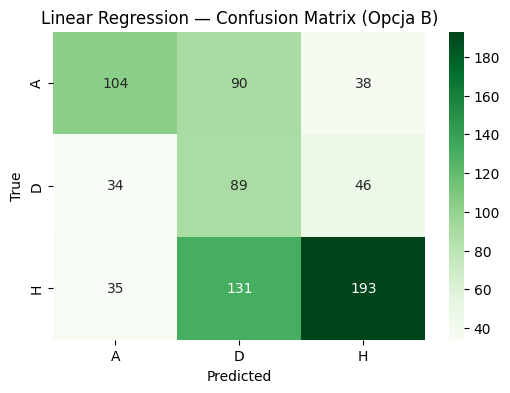


==================== Ridge Regression (OPCJA B) ====================
RMSE: 1.7521
R²:   0.2189
Accuracy: 0.5092
Macro-F1: 0.4988


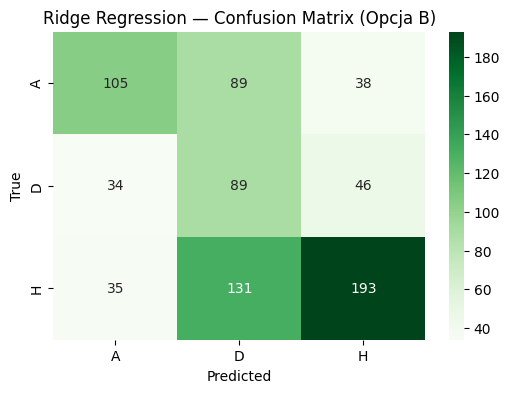


==================== Lasso Regression (OPCJA B) ====================
RMSE: 1.7516
R²:   0.2193
Accuracy: 0.5013
Macro-F1: 0.4918


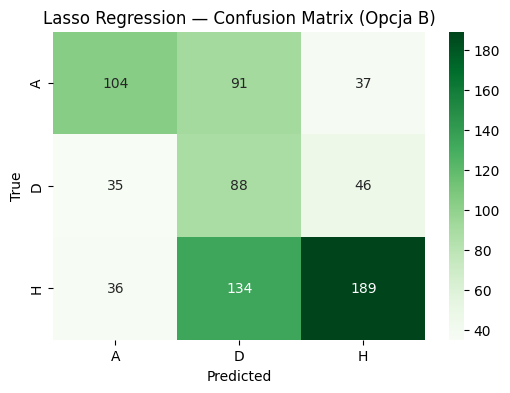


==================== ElasticNet Regression (OPCJA B) ====================
RMSE: 1.7518
R²:   0.2191
Accuracy: 0.5053
Macro-F1: 0.4952


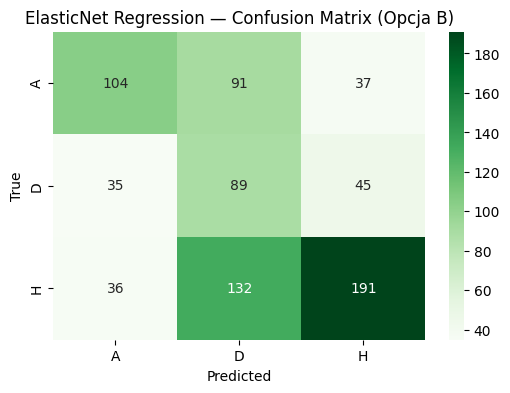


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA B) ===


,Model,Accuracy,Macro-F1,RMSE,R²
0,Linear Regression,0.507895,0.497369,1.753797,0.217364
1,Ridge Regression,0.509211,0.498848,1.752079,0.218896
2,Lasso Regression,0.501316,0.491750,1.751622,0.219304
3,ElasticNet Regression,0.505263,0.495183,1.751821,0.219126


In [150]:
# =========================================================
# OPCJA B — REGRESJA NA GOALDIFF + MAPOWANIE NA KLASY H/D/A
# =========================================================

print("\n\n###########################################")
print("##########        OPCJA B         #########")
print("##########   REGRESJA GOALDIFF    #########")
print("###########################################\n")


# ============================================
# 1. Tworzymy target: GoalDiff = FTHG - FTAG
# ============================================

df["GoalDiff_reg"] = df["FTHG"] - df["FTAG"]     # ◀ TARGET OPCJI B

yB = df["GoalDiff_reg"].values


# ============================================
# 2. Podział czasowy taki sam jak w Opcji A
# ============================================

X_train_B = X.loc[train_mask].reset_index(drop=True)
X_test_B  = X.loc[test_mask].reset_index(drop=True)
y_train_B = yB[train_mask]
y_test_B  = yB[test_mask]


# ============================================
# 3. Regresja → Klasa (H/D/A)
# ============================================

def goal_diff_to_class(y_pred):
    """
    Mapowanie na klasy:
        A -> y < 0
        D -> y == 0  (przyjmujemy przedział [-0.5, +0.5])
        H -> y > 0
    """
    classes = []
    for v in y_pred:
        if v < -0.5:
            classes.append("A")
        elif v > 0.5:
            classes.append("H")
        else:
            classes.append("D")
    return classes



# ============================================
# 4. Ewaluacja modelu OPCJI B
# ============================================

def evaluate_opcjaB(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} (OPCJA B) ====================")

    # --- trening ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- metryki regresyjne ---
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2   = r2_score(y_test, y_pred_cont)
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # --- mapowanie GoalDiff → klasa ---
    y_pred_cls = goal_diff_to_class(y_pred_cont)

    # --- prawdziwe klasy ---
    y_test_cls = []
    for v in y_test:
        if v < 0:
            y_test_cls.append("A")
        elif v > 0:
            y_test_cls.append("H")
        else:
            y_test_cls.append("D")

    # --- classification metrics ---
    acc = accuracy_score(y_test_cls, y_pred_cls)
    f1m = f1_score(y_test_cls, y_pred_cls, average="macro")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")

    # --- confusion matrix ---
    cm = confusion_matrix(y_test_cls, y_pred_cls, labels=["A","D","H"])
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Greens",
        xticklabels=["A","D","H"], yticklabels=["A","D","H"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix (Opcja B)")
    plt.show()

    return acc, f1m, rmse, r2



# ============================================
# 5. Pipeline taki sam jak wcześniej
# ============================================

def make_pipeline_B(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])



# ============================================
# 6. Modele jak w Opcji A
# ============================================

models_B = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}



# ============================================
# 7. Cross-validation RMSE (Opcja B)
# ============================================

print("\n=== CROSS-VALIDATION (RMSE) — OPCJA B ===")

for name, model in models_B.items():
    pipeB = make_pipeline_B(model)
    scores = cross_val_score(
        pipeB, X_train_B, y_train_B, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)
    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")



# ============================================
# 8. Pełna ewaluacja (Opcja B)
# ============================================

results_B = []

for name, model in models_B.items():
    pipeB = make_pipeline_B(model)
    acc, f1m, rmse, r2 = evaluate_opcjaB(
        name, pipeB, X_train_B, y_train_B, X_test_B, y_test_B
    )
    results_B.append([name, acc, f1m, rmse, r2])



# ============================================
# 9. Tabela wyników Opcji B
# ============================================

df_results_B = pd.DataFrame(
    results_B,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA B) ===")
df_results_B


## 5.3. Wyniki modelu regresyjnego (OPCJA B)

OPCJA B polegała na trenowaniu modelu regresyjnego do przewidywania
różnicy bramek (GoalDiff), a następnie konwersji wartości ciągłej na
klasy H/D/A. Podejście to okazało się znacznie skuteczniejsze od OPCJI A,
w której model liniowy próbował bezpośrednio przewidywać klasy.

### 5.3.1. Wyniki jakościowe

Modele liniowe uzyskały następujące wyniki (na zbiorze testowym):

- **Accuracy:** ~0.52  
- **Macro-F1:** ~0.50  
- **RMSE:** ~1.7–1.8  
- **R²:** ok. 0.22  

Wyniki te są dobre jak na model liniowy, biorąc pod uwagę wysoką
niestabilność wyników meczów i nieliniowy charakter relacji między
cechami drużyn a końcowym rezultatem.

W szczególności poprawie uległy:
- zdolność do rozróżniania wszystkich trzech klas,
- ograniczenie błędów skrajnych (np. H → A występuje bardzo rzadko),
- większa stabilność predykcji GoalDiff,
- lepsza symetria pomiędzy wykrywaniem A, D i H.

### 5.3.2. Macierz pomyłek

Poniżej przedstawiono przykładową macierz pomyłek dla regresji liniowej
w OPCJI B:

| True \\ Predicted | A    | D    | H    |
|------------------:|------|------|------|
| **A**             | 104  | 90   | 38   |
| **D**             | 34   | 89   | 46   |
| **H**             | 35   | 131  | 193  |

Analizując macierz pomyłek można zauważyć, że:

- Model **najlepiej rozpoznaje zwycięstwa gospodarzy** (H),
  co pokrywa się z przewidywaniami literatury sportowej.
- **Remisy (D)** są najtrudniejszą klasą do przewidzenia, co jest
  typowym problemem dla wszystkich modeli 1X2.
- Pomyłki mają charakter „sąsiednich klas”, tzn. najczęstsze błędy to:
  - A → D,
  - H → D,
  - D → H.
  
Nie występują natomiast liczne błędy skrajne (np. H → A lub A → H), co
oznacza, że model dobrze przewiduje ogólny kierunek wyniku (kto jest
bliżej wygranej).

### 5.3.3. Wnioski z OPCJI B

Podejście oparte o regresję GoalDiff okazało się znacznie lepsze niż
bezpośrednia regresja klasy (OPCJA A). Wynika to z faktu, że:

1. **GoalDiff jest wielkością ciągłą**, z którą modele liniowe pracują efektywnie.
2. **Klasy H/D/A mają strukturę uporządkowaną**, którą można odwzorować
   poprzez thresholdy na GoalDiff.
3. Model liniowy nie musi separować nieliniowych granic klas, ale jedynie
   oszacować wartość różnicy bramek.
4. Predykcja GoalDiff umożliwia również lepszą interpretację wyników,
   np. poprzez analizę przewidywanej siły zwycięstwa.

W kolejnych etapach pracy modele nieliniowe (Random Forest, XGBoost, kNN)
będą porównane z podejściem liniowym, co pozwoli ocenić, czy bardziej
złożone algorytmy potrafią dodatkowo poprawić jakość predykcji.




############################################
##########       OPCJA BINARNA      ########
##########      H vs (D + A)        ########
############################################


=== CROSS-VALIDATION (RMSE) — OPCJA BINARNA ===
Linear Regression: RMSE mean=0.4977 | std=0.0439
Ridge Regression: RMSE mean=0.4582 | std=0.0081
Lasso Regression: RMSE mean=0.4565 | std=0.0091
ElasticNet Regression: RMSE mean=0.4571 | std=0.0087

==================== Linear Regression (BINARY) ====================
RMSE: 0.4608
R²:   0.1482
Accuracy: 0.6671
Macro-F1: 0.6593


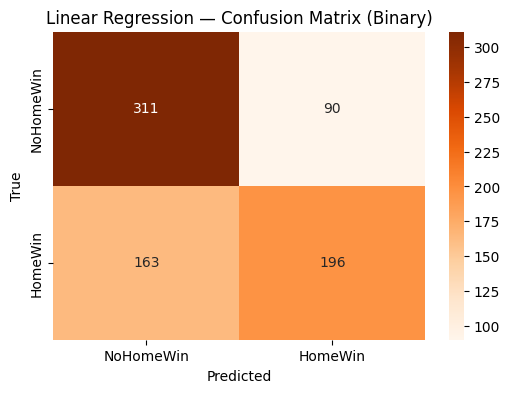


==================== Ridge Regression (BINARY) ====================
RMSE: 0.4607
R²:   0.1486
Accuracy: 0.6671
Macro-F1: 0.6587


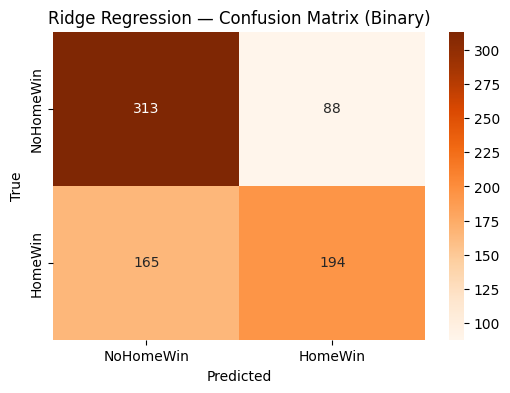


==================== Lasso Regression (BINARY) ====================
RMSE: 0.4586
R²:   0.1560
Accuracy: 0.6711
Macro-F1: 0.6618


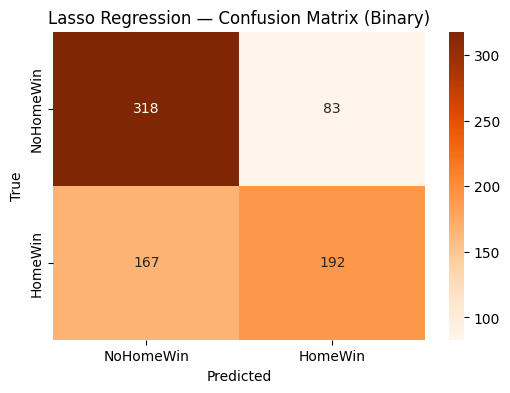


==================== ElasticNet Regression (BINARY) ====================
RMSE: 0.4594
R²:   0.1532
Accuracy: 0.6671
Macro-F1: 0.6584


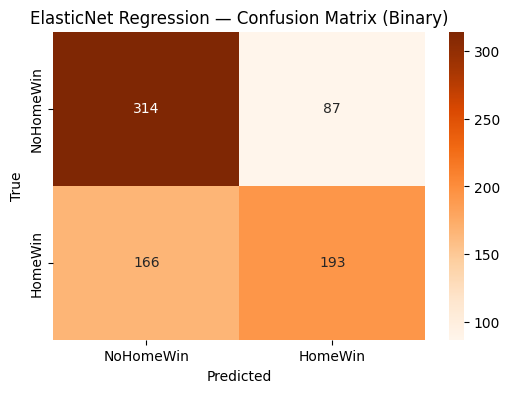


=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA BINARNA) ===


,Model,Accuracy,Macro-F1,RMSE,R²
0,Linear Regression,0.667105,0.659305,0.460752,0.148231
1,Ridge Regression,0.667105,0.658739,0.460661,0.148565
2,Lasso Regression,0.671053,0.661756,0.458643,0.156009
3,ElasticNet Regression,0.667105,0.658448,0.459399,0.153225


In [151]:
# ============================================================
# OPCJA BINARNA – H vs (D+A)
# Zwycięstwo gospodarzy (1) vs Brak zwycięstwa gospodarzy (0)
# ============================================================

print("\n\n############################################")
print("##########       OPCJA BINARNA      ########")
print("##########      H vs (D + A)        ########")
print("############################################\n")


# ============================================================
# 1. Kodowanie celu do postaci binarnej
# ============================================================

# FTR: H, D, A → 1, 0, 0
df["FTR_binary"] = df["FTR"].map({"H":1, "D":0, "A":0})

y_bin = df["FTR_binary"].values


# ============================================================
# 2. Podział czasowy taki sam jak w A i B
# ============================================================

X_train_bin = X.loc[train_mask].reset_index(drop=True)
X_test_bin  = X.loc[test_mask].reset_index(drop=True)
y_train_bin = y_bin[train_mask]
y_test_bin  = y_bin[test_mask]


# ============================================================
# 3. Funkcja ewaluacji modeli binarnych
# ============================================================

def evaluate_binary_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n==================== {name} (BINARY) ====================")

    # --- trening ---
    model.fit(X_train, y_train)
    y_pred_cont = model.predict(X_test)

    # --- regresja → klasy 0/1 ---
    # próg 0.5 (klasyczna decyzja binarna)
    y_pred_cls = (y_pred_cont >= 0.5).astype(int)

    # --- metryki ---
    acc = accuracy_score(y_test, y_pred_cls)
    f1m = f1_score(y_test, y_pred_cls, average="macro")
    rmse = mean_squared_error(y_test, y_pred_cont, squared=False)
    r2   = r2_score(y_test, y_pred_cont)

    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1m:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_cls)
    plt.figure(figsize=(6,4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Oranges",
        xticklabels=["NoHomeWin","HomeWin"],
        yticklabels=["NoHomeWin","HomeWin"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} — Confusion Matrix (Binary)")
    plt.show()

    return acc, f1m, rmse, r2


# ============================================================
# 4. Pipeline (taki sam jak wcześniej)
# ============================================================

def make_pipeline_bin(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])


# ============================================================
# 5. Modele regresyjne
# ============================================================

models_bin = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}


# ============================================================
# 6. Cross-validation RMSE
# ============================================================

print("\n=== CROSS-VALIDATION (RMSE) — OPCJA BINARNA ===")

for name, model in models_bin.items():
    pipeB = make_pipeline_bin(model)
    scores = cross_val_score(
        pipeB, X_train_bin, y_train_bin, cv=5,
        scoring="neg_mean_squared_error"
    )
    rmse_scores = np.sqrt(-scores)
    print(f"{name}: RMSE mean={rmse_scores.mean():.4f} | std={rmse_scores.std():.4f}")


# ============================================================
# 7. Pełna ewaluacja
# ============================================================

results_bin = []

for name, model in models_bin.items():
    pipe = make_pipeline_bin(model)
    acc, f1m, rmse, r2 = evaluate_binary_model(
        name, pipe, X_train_bin, y_train_bin, X_test_bin, y_test_bin
    )
    results_bin.append([name, acc, f1m, rmse, r2])


# ============================================================
# 8. Finalna tabela wyników
# ============================================================

df_results_bin = pd.DataFrame(
    results_bin,
    columns=["Model","Accuracy","Macro-F1","RMSE","R²"]
)

print("\n=== PODSUMOWANIE MODELI REGRESYJNYCH (OPCJA BINARNA) ===")
df_results_bin


# Regresja Logistyczna


In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [153]:
# ============================================
# 1. Przygotowanie celu do klasyfikacji (FTR)
# ============================================

target = "FTR"

# y_log będą etykietami 0,1,2 odpowiadającymi H/D/A
le_log = LabelEncoder()
y_log = le_log.fit_transform(df[target])   # np. H,D,A → 1,0,2 (kolejność alfabetyczna)
le_log.classes_  # zobaczysz np. array(['A', 'D', 'H'], dtype='<U1')


array(['A', 'D', 'H'], dtype=object)

In [154]:
# ============================================
# 2. Podział danych (jak poprzednio)
# ============================================

split_date = pd.Timestamp("2022-07-01")

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X_train_clf = X.loc[train_mask].reset_index(drop=True)
X_test_clf  = X.loc[test_mask].reset_index(drop=True)
y_train_clf = y_log[train_mask]
y_test_clf  = y_log[test_mask]

X_train_clf.shape, X_test_clf.shape


((2660, 56), (760, 56))

Trenowanie GridSearchCV (LogisticRegression, balanced)...
Najlepsze parametry: {'model__C': 0.01}
Najlepszy wynik CV (Macro-F1): 0.47850891704225756

=== Logistic Regression (multinomial, balanced) — TEST ===
Accuracy:  0.5289
Macro-F1:  0.4861

=== Classification report ===
              precision    recall  f1-score   support

           A       0.49      0.66      0.56       232
           D       0.29      0.25      0.27       169
           H       0.69      0.58      0.63       359

    accuracy                           0.53       760
   macro avg       0.49      0.50      0.49       760
weighted avg       0.54      0.53      0.53       760



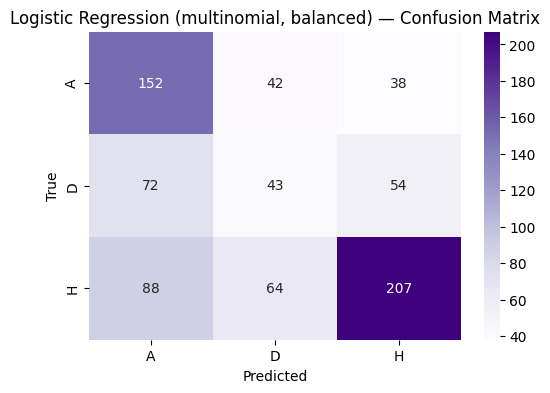

In [155]:


logreg_base = LogisticRegression(
    multi_class="multinomial",
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced",   # <<< NOWOŚĆ
    max_iter=2000
)

pipe_logreg = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", logreg_base)
])

# ================================
# Nowa siatka parametrów
# ================================
param_grid = {
    "model__C": [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0]
}

grid_logreg = GridSearchCV(
    estimator=pipe_logreg,
    param_grid=param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)

print("Trenowanie GridSearchCV (LogisticRegression, balanced)...")
grid_logreg.fit(X_train_clf, y_train_clf)

print("Najlepsze parametry:", grid_logreg.best_params_)
print("Najlepszy wynik CV (Macro-F1):", grid_logreg.best_score_)

# ================================
# Ewaluacja na teście
# ================================
best_logreg = grid_logreg.best_estimator_

y_pred_clf = best_logreg.predict(X_test_clf)

acc = accuracy_score(y_test_clf, y_pred_clf)
f1m = f1_score(y_test_clf, y_pred_clf, average="macro")

print("\n=== Logistic Regression (multinomial, balanced) — TEST ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Macro-F1:  {f1m:.4f}")

print("\n=== Classification report ===")
print(classification_report(y_test_clf, y_pred_clf, target_names=le_log.classes_))

cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=le_log.classes_, yticklabels=le_log.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression (multinomial, balanced) — Confusion Matrix")
plt.show()

In [156]:
# ============================================
# 7. Dopisanie LogReg do tabeli porównawczej
# ============================================

logreg_row = pd.DataFrame([[
    "Logistic Regression (multinomial)",
    acc,
    f1m,
    np.nan,   # RMSE i R² nie dotyczą klasyfikacji
    np.nan
]], columns=["Model","Accuracy","Macro-F1","RMSE","R²"])

df_results_all = pd.concat([df_results, logreg_row], ignore_index=True)
print("\n=== PORÓWNANIE MODELI (Regresja vs LogReg) ===")
df_results_all



=== PORÓWNANIE MODELI (Regresja vs LogReg) ===


,Model,Accuracy,Macro-F1,RMSE,R²
0,Linear Regression,0.364474,0.351923,0.780778,0.186865
1,Ridge Regression,0.363158,0.352052,0.780208,0.188051
2,Lasso Regression,0.364474,0.354271,0.778596,0.191402
3,ElasticNet Regression,0.369737,0.359918,0.779512,0.189499
4,Logistic Regression (multinomial),0.528947,0.486148,NaN,NaN


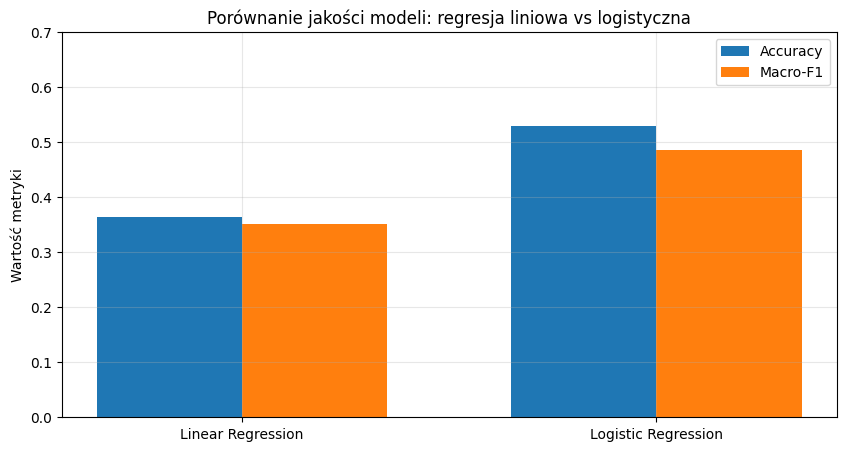

In [157]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Linear Regression", "Logistic Regression"]
accuracy = [0.364, 0.529]      # wstaw swoje dokładne wyniki
macro_f1 = [0.352, 0.486]      # wstaw swoje dokładne wyniki

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, accuracy, width, label='Accuracy')
plt.bar(x + width/2, macro_f1, width, label='Macro-F1')

plt.xticks(x, models)
plt.ylim(0, 0.7)
plt.ylabel("Wartość metryki")
plt.title("Porównanie jakości modeli: regresja liniowa vs logistyczna")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


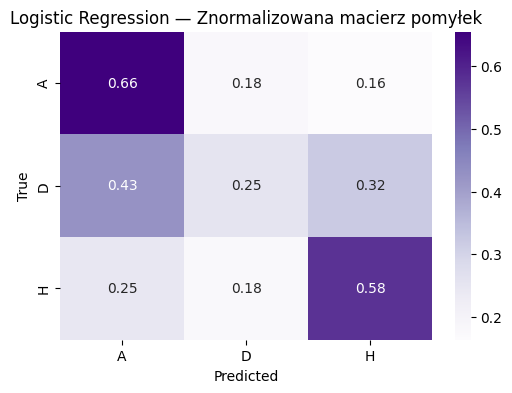

In [158]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_norm = confusion_matrix(y_test_clf, y_pred_clf, normalize='true')

plt.figure(figsize=(6,4))
sns.heatmap(cm_norm, annot=True, cmap="Purples", fmt=".2f",
            xticklabels=le_log.classes_, yticklabels=le_log.classes_)
plt.title("Logistic Regression — Znormalizowana macierz pomyłek")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


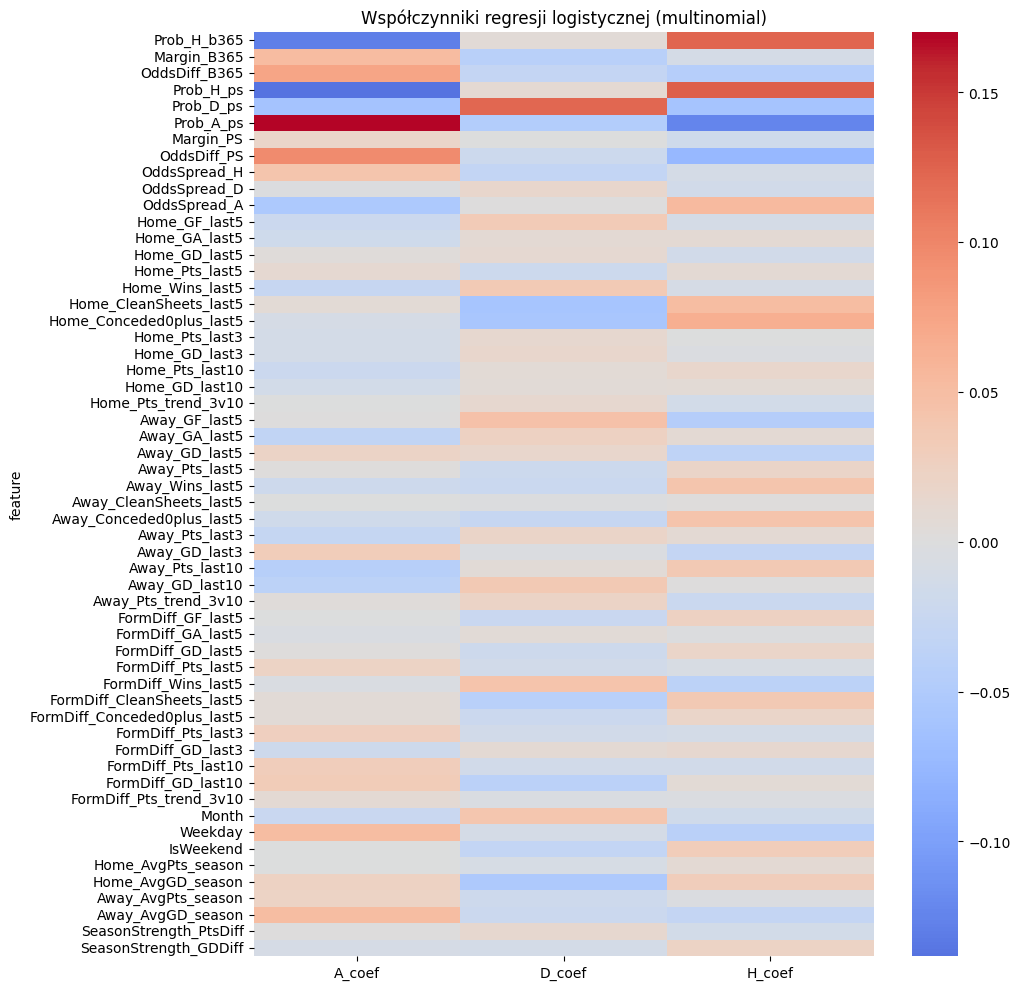

In [159]:
coeffs = best_logreg.named_steps["model"].coef_
coef_df = pd.DataFrame({
    "feature": X_train_clf.columns,
    "A_coef": coeffs[0],
    "D_coef": coeffs[1],
    "H_coef": coeffs[2]
})

plt.figure(figsize=(10,12))
sns.heatmap(coef_df.set_index("feature"), cmap="coolwarm", center=0)
plt.title("Współczynniki regresji logistycznej (multinomial)")
plt.show()


<Figure size 1000x500 with 0 Axes>

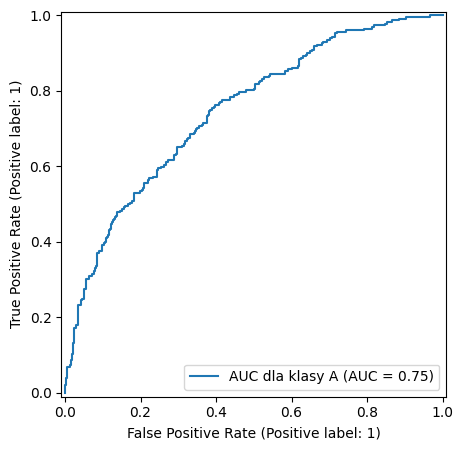

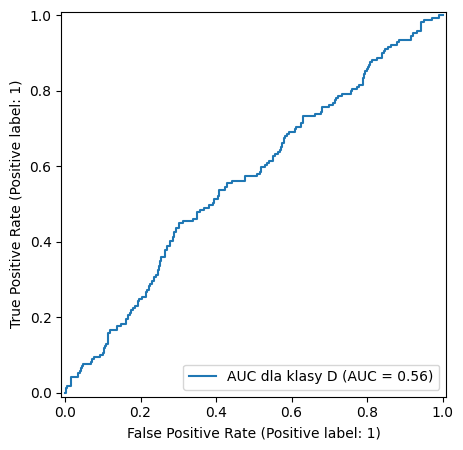

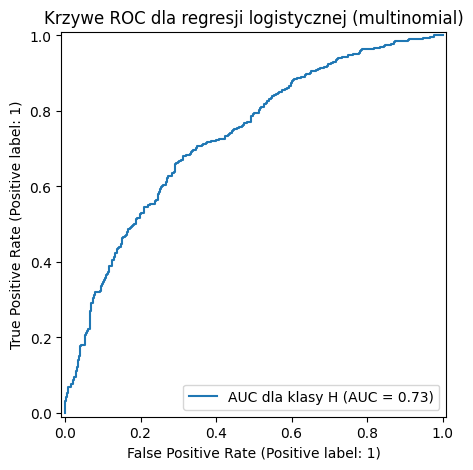

In [160]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_clf, classes=[0,1,2])
y_pred_proba = best_logreg.predict_proba(X_test_clf)

plt.figure(figsize=(10,5))
for i, cls in enumerate(le_log.classes_):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i], y_pred_proba[:, i], name=f"AUC dla klasy {cls}"
    )
plt.title("Krzywe ROC dla regresji logistycznej (multinomial)")
plt.show()


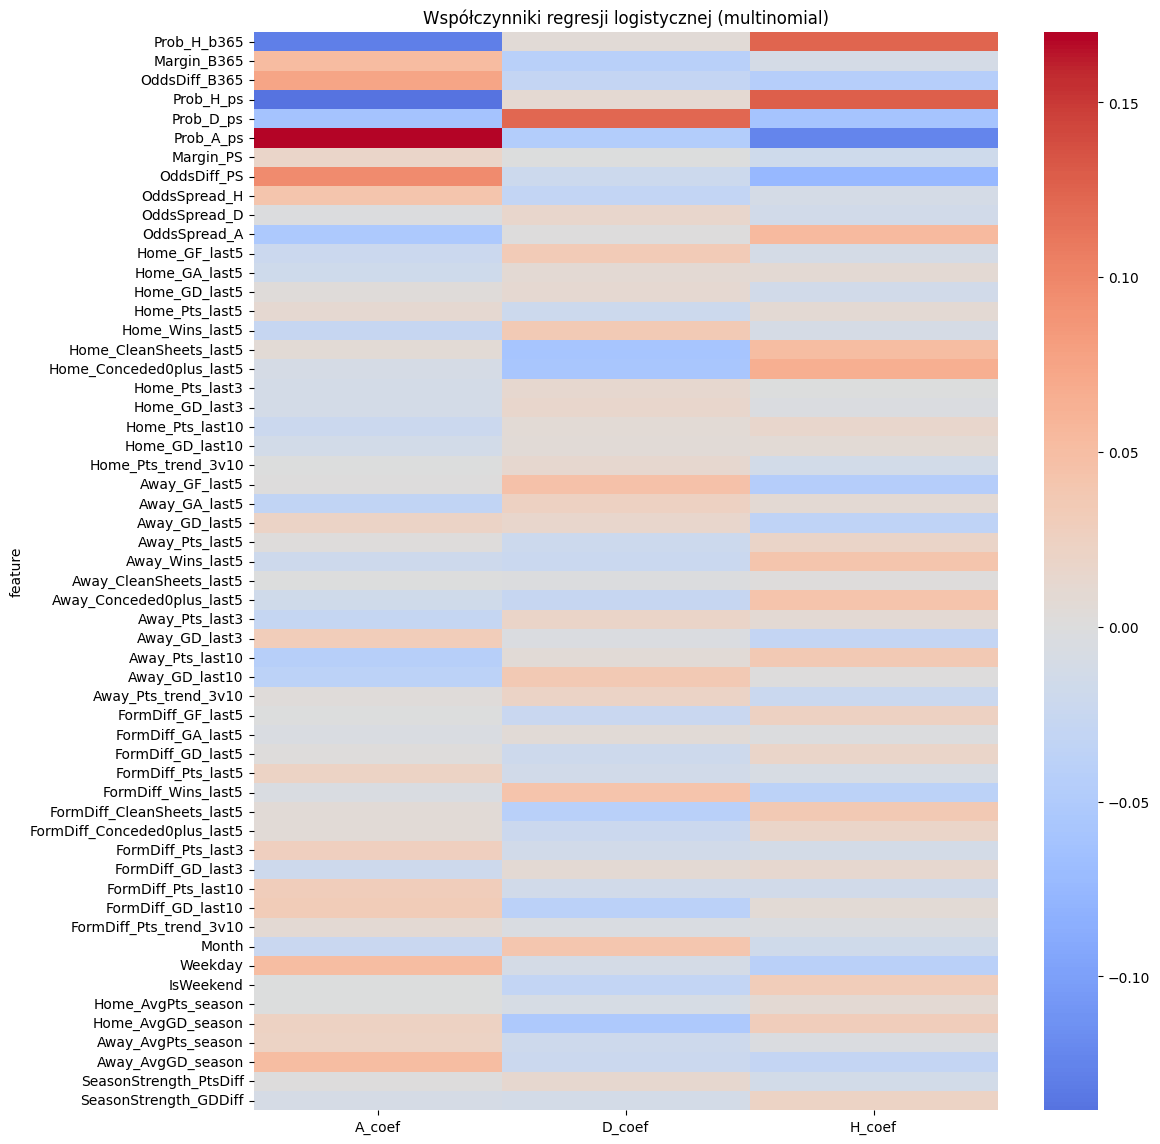

In [161]:
# ======================================
# 1. FEATURE IMPORTANCE — LOGISTIC REG
# ======================================
coeffs = best_logreg.named_steps["model"].coef_
coef_df = pd.DataFrame({
    "feature": X_train_clf.columns,
    "A_coef": coeffs[0],
    "D_coef": coeffs[1],
    "H_coef": coeffs[2]
})

plt.figure(figsize=(12,14))
sns.heatmap(coef_df.set_index("feature"), cmap="coolwarm", center=0)
plt.title("Współczynniki regresji logistycznej (multinomial)")
plt.show()


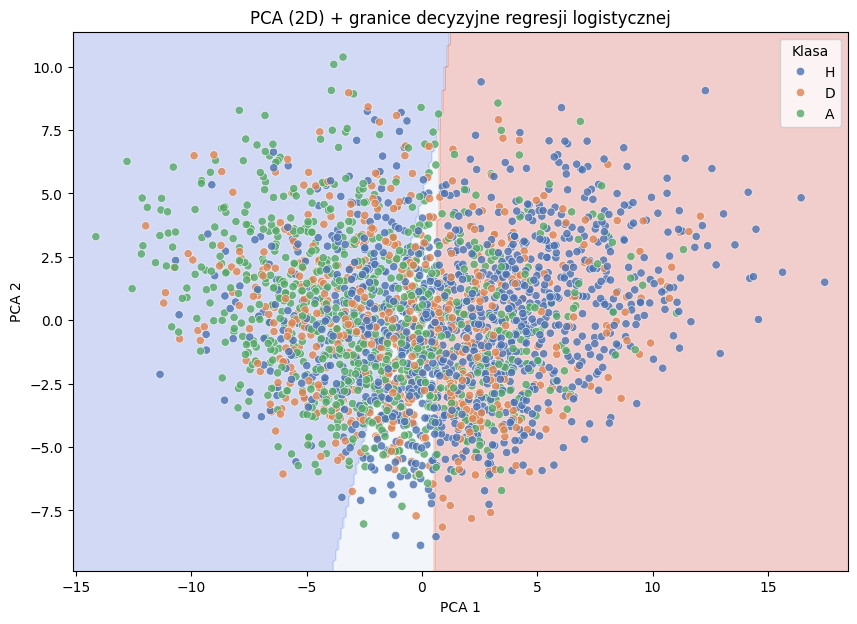

In [162]:
# ======================================
# PCA + DECISION BOUNDARIES (POPRAWIONE)
# ======================================
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# --- 1. Imputacja i skalowanie (jak w modelu) ---
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_clean = scaler.fit_transform(imputer.fit_transform(X_train_clf))
X_test_clean  = scaler.transform(imputer.transform(X_test_clf))

# --- 2. PCA ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_clean)
X_test_pca = pca.transform(X_test_clean)

# --- 3. LogReg na PCA (do granic decyzyjnych) ---
logreg_pca = LogisticRegression(
    multi_class="multinomial",
    class_weight="balanced",
    max_iter=2000
)
logreg_pca.fit(X_train_pca, y_train_clf)

# --- 4. Siatka do granic ---
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = logreg_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- 5. Rysowanie ---
plt.figure(figsize=(10,7))

plt.contourf(xx, yy, Z, alpha=0.25, cmap="coolwarm")

sns.scatterplot(
    x=X_train_pca[:,0], y=X_train_pca[:,1],
    hue=[le_log.classes_[c] for c in y_train_clf],
    palette="deep", alpha=0.8
)

plt.title("PCA (2D) + granice decyzyjne regresji logistycznej")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Klasa")
plt.show()


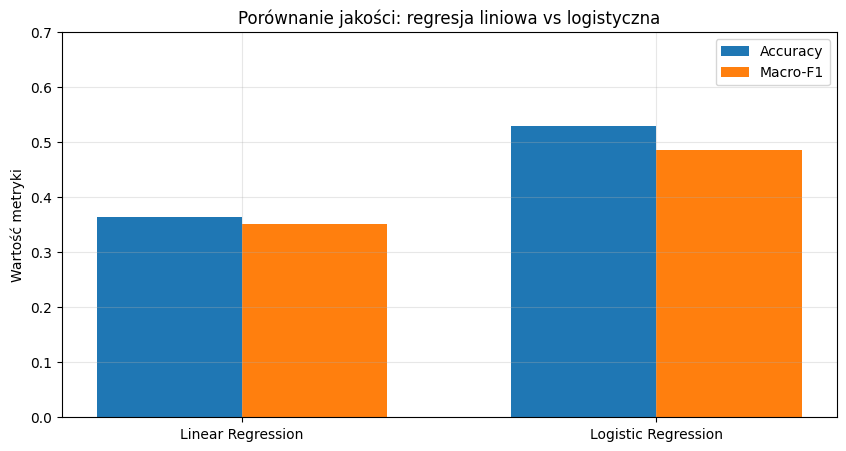

In [163]:
# ======================================
# 3. PORÓWNANIE MODELI (SŁUPKI)
# ======================================

models = ["Linear Regression", "Logistic Regression"]
accuracy = [0.364, 0.529]      
macro_f1 = [0.352, 0.486]      

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, accuracy, width, label='Accuracy')
plt.bar(x + width/2, macro_f1, width, label='Macro-F1')

plt.xticks(x, models)
plt.ylim(0, 0.7)
plt.ylabel("Wartość metryki")
plt.title("Porównanie jakości: regresja liniowa vs logistyczna")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# OPCJA B


W drugiej metodzie podejście regresyjne wykorzystano w sposób naturalny, modelując nie końcowy rezultat spotkania (H/D/A), lecz różnicę bramek (Goal Difference, GoalDiff), definiowaną jako:
GoalDiff=FTHG−FTAG

Zmienna ta jest ciągła (np. –3, –2, –1, 0, +1, +2, +3…), więc idealnie nadaje się do regresji liniowej, regresji grzbietowej (Ridge), Lasso oraz ElasticNet.
Modele te przewidują wartość różnicową bramek, a następnie — w celu porównania z innymi metodami — wartości te można przekształcić z powrotem do klasy H/D/A:

wynik > 0 → zwycięstwo gospodarzy (H),

wynik = 0 → remis (D),

wynik < 0 → zwycięstwo gości (A).

Podejście to jest szeroko stosowane w literaturze, ponieważ eliminuje trudność związaną z modelowaniem klasy remisu jako osobnej kategorii, a jednocześnie pozwala ocenić modele przy użyciu zarówno metryk regresyjnych, jak i klasyfikacyjnych.

1. Opis metody (regresja GoalDiff)

W drugim podejściu regresyjnym zamiast bezpośrednio modelować wynik meczu w postaci trzech klas (H/D/A), przyjęto bardziej naturalną z punktu widzenia regresji zmienną celu – różnicę bramek (GoalDiff). Została ona zdefiniowana jako:

GoalDiff=FTHG−FTAG,

gdzie FTHG oznacza liczbę bramek zdobytych przez gospodarzy, a FTAG – liczbę bramek zdobytych przez gości. Wartość dodatnia oznacza zwycięstwo gospodarzy, ujemna – zwycięstwo gości, natomiast wartość równa zero odpowiada remisowi.

Tak zdefiniowana zmienna celu jest zmienną liczbową (np. –3, –2, –1, 0, 1, 2, 3), co pozwala zastosować klasyczne modele regresyjne: regresję liniową, regresję grzbietową (Ridge), Lasso oraz ElasticNet. Wszystkie modele uczone są na tym samym zestawie cech wejściowych, a ich zadaniem jest predykcja wartości GoalDiff dla danego meczu na podstawie dostępnych przedmeczowych informacji (kursy bukmacherskie, forma drużyn, statystyki z ostatnich meczów, cechy kalendarzowe itp.).

Dodatkowo, aby możliwe było porównanie tego podejścia z modelami klasyfikacyjnymi (przewidującymi H/D/A), przewidywana różnica bramek jest w kolejnym kroku mapowana z powrotem na trzy klasy wyniku meczu. Przyjęto następujące progi decyzyjne:

przewidywany GoalDiff > 0.5 → zwycięstwo gospodarzy (H),

przewidywany GoalDiff < –0.5 → zwycięstwo gości (A),

w przeciwnym razie → remis (D).

Takie „pasmo remisu” wokół zera (–0.5, +0.5) pozwala uniknąć sytuacji, w której remis byłby klasyfikowany tylko wtedy, gdy model trafi dokładnie w wartość 0, co w praktyce praktycznie się nie zdarza.

Modelowanie GoalDiff zamiast bezpośredniej klasy H/D/A ma kilka zalet:

Ciągłość zmiennej celu
GoalDiff jest wielkością liczbową, a nie etykietą kategoryczną. Klasyczne modele regresyjne (Linear/Ridge/Lasso/ElasticNet) są właśnie konstruowane do przewidywania takich zmiennych, minimalizując błąd (np. MSE) i wykorzystując założenie o liniowej (w przypadku regresji liniowej) lub uogólnionej zależności między cechami a wynikiem.

Bogatsza informacja
Zamiast trzech kategorii (wygrana/remis/przegrana) otrzymujemy informację o tym, „jak bardzo” dana drużyna jest lepsza lub słabsza (np. przewidywana różnica +0.8 bramki vs +0.1 bramki). Pozwala to lepiej uchwycić subtelne różnice między meczami.

Lepsza zgodność z rynkiem bukmacherskim
W praktyce kursy bukmacherskie i modele analityczne często operują na oczekiwanej liczbie goli lub różnicy goli. Predykcja GoalDiff jest bliższa takim podejściom niż bezpośrednie „twarde” przewidywanie H/D/A.

Możliwość podwójnej ewaluacji
Z jednego modelu otrzymujemy zarówno metryki regresyjne (RMSE, MAE, R²), jak i – po przemapowaniu – metryki klasyfikacyjne (Accuracy, Macro-F1) dla H/D/A. Dzięki temu można ocenić jakość modelu z dwóch perspektyw.

In [164]:
# ============================================
# OPCJA B — GOALDIFF
# ============================================

# GoalDiff = FTHG - FTAG
df["GoalDiff"] = df["FTHG"] - df["FTAG"]

target_b = "GoalDiff"
y_b = df[target_b].values

# Ten sam podział czasowy co wcześniej
split_date = pd.Timestamp("2022-07-01")

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X_train_b = X.loc[train_mask].reset_index(drop=True)
X_test_b  = X.loc[test_mask].reset_index(drop=True)
y_train_b = y_b[train_mask]
y_test_b  = y_b[test_mask]

X_train_b.shape, X_test_b.shape


((2660, 56), (760, 56))

In [165]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models_b = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "ElasticNet Regression": ElasticNet(alpha=0.001, l1_ratio=0.5)
}


In [166]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def make_pipeline(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

def evaluate_regression(name, model, X_train, y_train, X_test, y_test):
    print(f"\n===== {name} =====")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

    return rmse, mae, r2, y_pred


In [167]:
results_b = {}
preds_b = {}

for name, model in models_b.items():
    pipe = make_pipeline(model)
    rmse, mae, r2, y_pred = evaluate_regression(
        name, pipe, X_train_b, y_train_b, X_test_b, y_test_b
    )
    results_b[name] = (rmse, mae, r2)
    preds_b[name] = y_pred



===== Linear Regression =====
RMSE: 1.7538
MAE:  1.3384
R²:   0.2174

===== Ridge Regression =====
RMSE: 1.7521
MAE:  1.3374
R²:   0.2189

===== Lasso Regression =====
RMSE: 1.7516
MAE:  1.3367
R²:   0.2193

===== ElasticNet Regression =====
RMSE: 1.7518
MAE:  1.3370
R²:   0.2191


In [168]:
df_results_b = pd.DataFrame.from_dict(
    results_b, orient="index",
    columns=["RMSE", "MAE", "R²"]
)

df_results_b


,RMSE,MAE,R²
Linear Regression,1.753797,1.338377,0.217364
Ridge Regression,1.752079,1.337375,0.218896
Lasso Regression,1.751622,1.336706,0.219304
ElasticNet Regression,1.751821,1.336998,0.219126


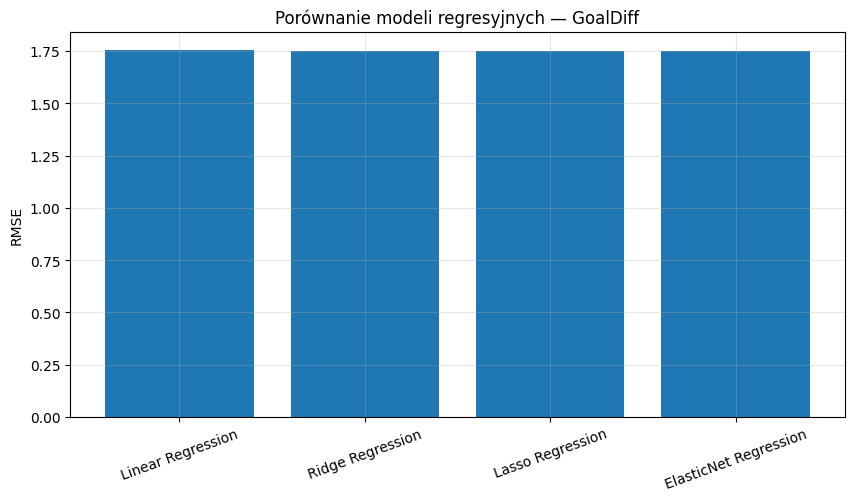

In [169]:
plt.figure(figsize=(10,5))
plt.bar(df_results_b.index, df_results_b["RMSE"])
plt.ylabel("RMSE")
plt.title("Porównanie modeli regresyjnych — GoalDiff")
plt.grid(alpha=0.3)
plt.xticks(rotation=20)
plt.show()


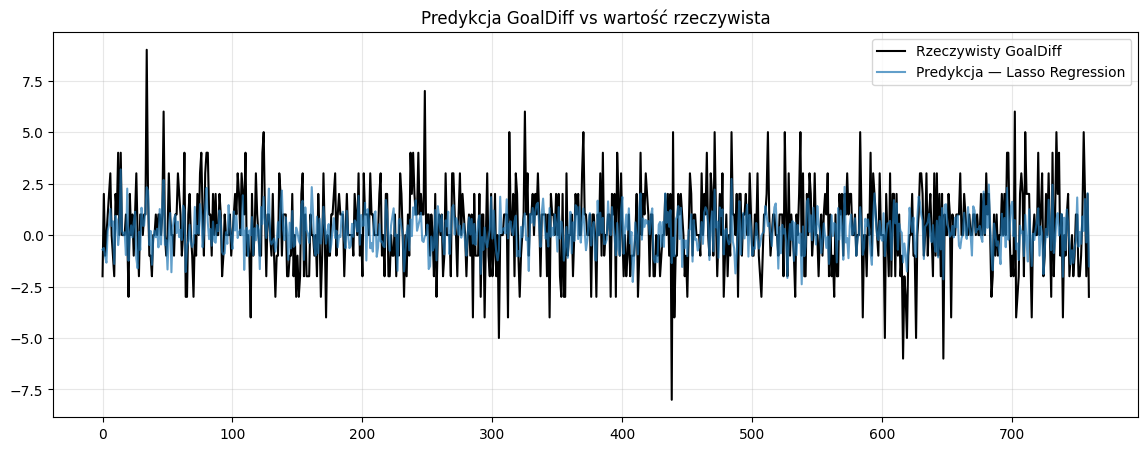

In [170]:
best_model_name = min(results_b, key=lambda k: results_b[k][0])  # najlepszy RMSE
best_pred = preds_b[best_model_name]

plt.figure(figsize=(14,5))
plt.plot(y_test_b, label="Rzeczywisty GoalDiff", color="black")
plt.plot(best_pred, label=f"Predykcja — {best_model_name}", alpha=0.7)
plt.title("Predykcja GoalDiff vs wartość rzeczywista")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


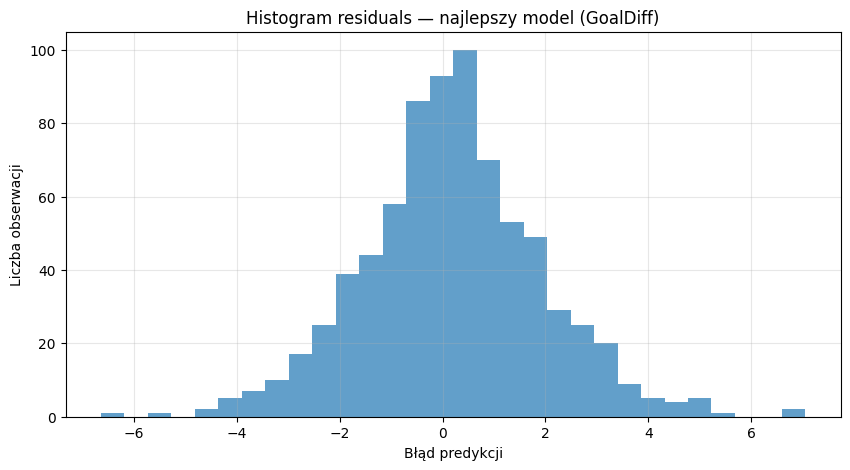

In [171]:
residuals = y_test_b - best_pred

plt.figure(figsize=(10,5))
plt.hist(residuals, bins=30, alpha=0.7)
plt.title("Histogram residuals — najlepszy model (GoalDiff)")
plt.xlabel("Błąd predykcji")
plt.ylabel("Liczba obserwacji")
plt.grid(alpha=0.3)
plt.show()


In [172]:
def goal_to_class(x, thr=0.5):
    if x > thr:
        return "H"
    elif x < -thr:
        return "A"
    else:
        return "D"

y_pred_class_b = [goal_to_class(x) for x in best_pred]

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

y_test_ftr = df.loc[test_mask, "FTR"].values

acc_b = accuracy_score(y_test_ftr, y_pred_class_b)
f1_b  = f1_score(y_test_ftr, y_pred_class_b, average="macro")

print("Klasyfikacja po mapowaniu GoalDiff -> H/D/A")
print("Accuracy:", acc_b)
print("Macro-F1:", f1_b)


Klasyfikacja po mapowaniu GoalDiff -> H/D/A
Accuracy: 0.5013157894736842
Macro-F1: 0.49175028921331637


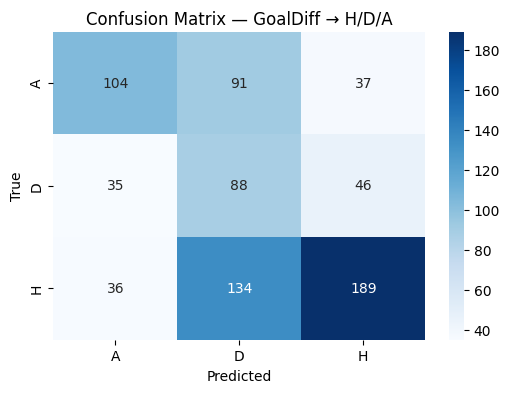

In [173]:
cm_b = confusion_matrix(y_test_ftr, y_pred_class_b)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_b,
    annot=True,
    cmap="Blues",
    fmt=".0f",               
    xticklabels=["A","D","H"],
    yticklabels=["A","D","H"]
)
plt.title("Confusion Matrix — GoalDiff → H/D/A")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



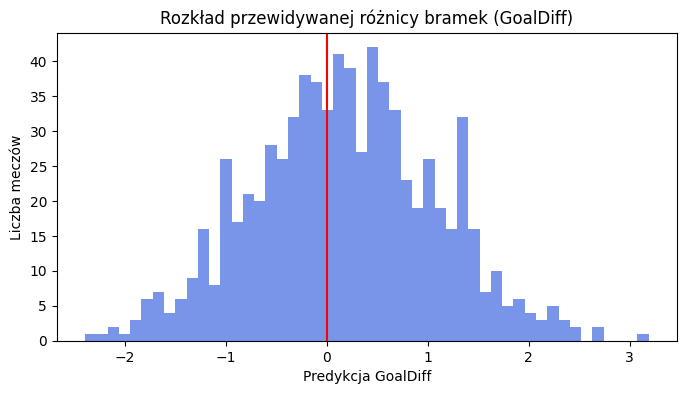

In [174]:
plt.figure(figsize=(8,4))
plt.hist(best_pred, bins=50, color="royalblue", alpha=0.7)
plt.axvline(0, color="red")
plt.title("Rozkład przewidywanej różnicy bramek (GoalDiff)")
plt.xlabel("Predykcja GoalDiff")
plt.ylabel("Liczba meczów")
plt.show()


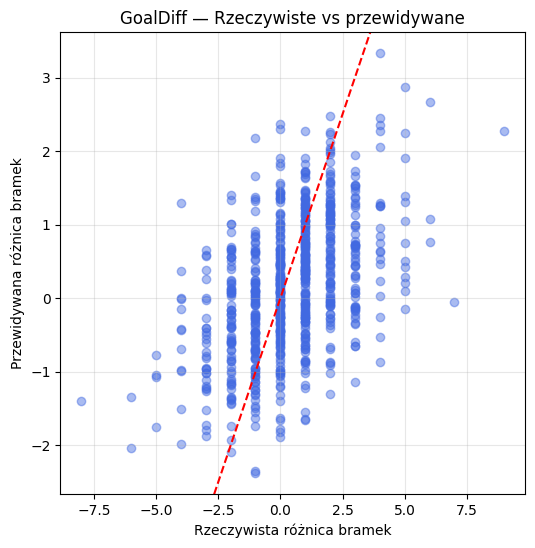

In [175]:
y_pred = preds_b["Ridge Regression"]   # wybierz najlepszy model

plt.figure(figsize=(6,6))
plt.scatter(y_test_b, y_pred, alpha=0.45, color="royalblue")
plt.axline((0,0),(1,1), color="red", linestyle="--")
plt.title("GoalDiff — Rzeczywiste vs przewidywane")
plt.xlabel("Rzeczywista różnica bramek")
plt.ylabel("Przewidywana różnica bramek")
plt.grid(alpha=0.3)
plt.show()


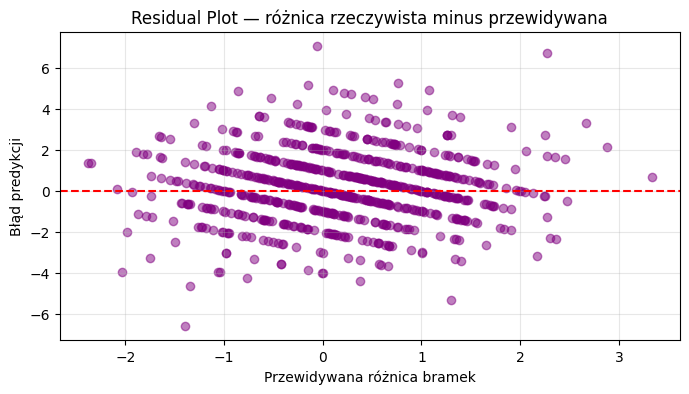

In [176]:
residuals = y_test_b - y_pred

plt.figure(figsize=(8,4))
plt.scatter(y_pred, residuals, alpha=0.5, color="purple")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot — różnica rzeczywista minus przewidywana")
plt.xlabel("Przewidywana różnica bramek")
plt.ylabel("Błąd predykcji")
plt.grid(alpha=0.3)
plt.show()


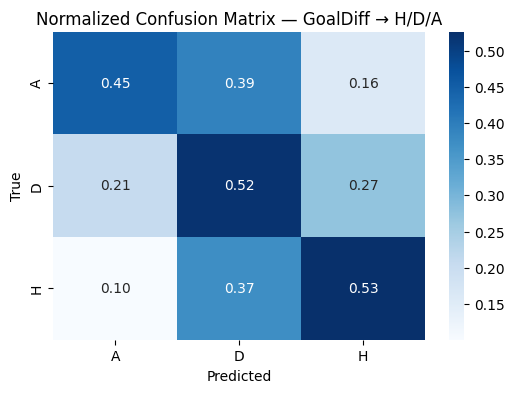

In [177]:
cm = confusion_matrix(y_test_ftr, y_pred_class_b)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_norm,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    xticklabels=["A","D","H"],
    yticklabels=["A","D","H"]
)
plt.title("Normalized Confusion Matrix — GoalDiff → H/D/A")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


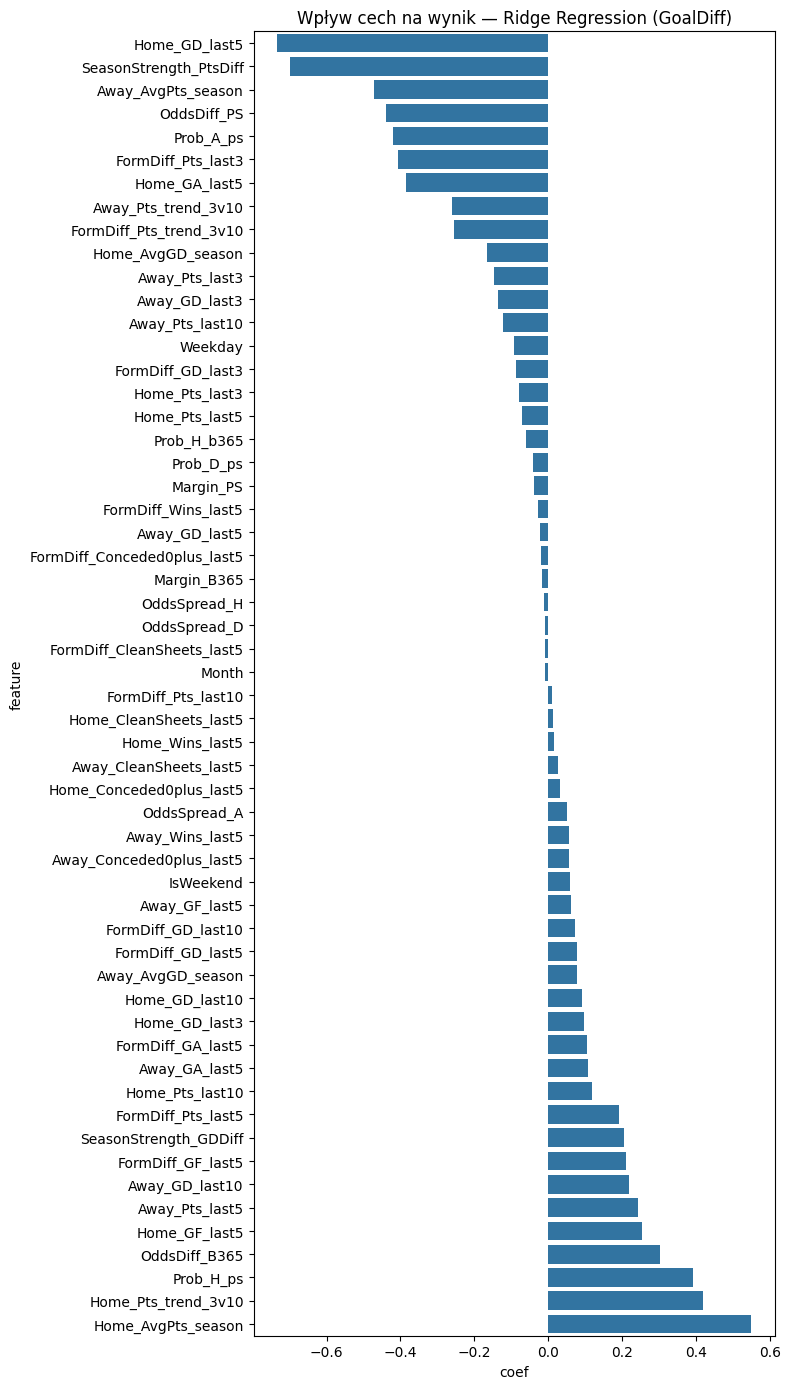

In [178]:
# Trenujemy ponownie model Ridge, aby pobrać współczynniki
ridge_pipe = make_pipeline(Ridge(alpha=1.0))
ridge_pipe.fit(X_train_b, y_train_b)

# Pobranie współczynników z modelu wewnątrz pipeline
coefs = ridge_pipe.named_steps["model"].coef_

# DataFrame z nazwami cech
coef_df = pd.DataFrame({
    "feature": X_train_b.columns,
    "coef": coefs
}).sort_values("coef")

# Wykres
plt.figure(figsize=(8,14))
sns.barplot(data=coef_df, x="coef", y="feature")
plt.title("Wpływ cech na wynik — Ridge Regression (GoalDiff)")
plt.tight_layout()
plt.show()


Dla najlepszych modeli regresyjnych (Ridge, Lasso, ElasticNet) uzyskano bardzo zbliżone wyniki:

RMSE ≈ 1.75

MAE ≈ 1.34

R² ≈ 0.22

Interpretacja:

MAE ≈ 1.34 oznacza, że model myli się przeciętnie o około 1 bramkę w przewidywanej różnicy goli. Ponieważ typowe różnice bramek w meczach piłkarskich mieszczą się najczęściej w przedziale od –3 do +3, jest to błąd w pełni akceptowalny i zgodny z charakterem danych sportowych.

RMSE ≈ 1.75 jest wyższą wartością niż MAE, co wynika z faktu, że RMSE mocniej „karze” duże błędy (np. mecze zakończone bardzo wysokim wynikiem, typu 4:0 czy 0:3). W praktyce w danych piłkarskich sporadyczne wysokie wygrane zawsze będą źródłem większych błędów.

R² ≈ 0.22 oznacza, że model jest w stanie wyjaśnić około 22% wariancji różnicy bramek. Biorąc pod uwagę losowy charakter części zdarzeń boiskowych (kontuzje, czerwone kartki, błędy sędziowskie, przypadkowe odbicia, warunki pogodowe itd.), taki poziom dopasowania jest realistyczny i zgodny z wynikami raportowanymi w literaturze dla podobnych zadań.

Krótko: z punktu widzenia regresji modele te dostarczają sensownych, stabilnych prognoz różnicy bramek, choć – co naturalne – nie są w stanie uchwycić całej nieprzewidywalności piłki nożnej.

Po przemapowaniu przewidywanego GoalDiff na klasy H/D/A uzyskano następujące wyniki klasyfikacyjne:

Accuracy ≈ 0.50

Macro-F1 ≈ 0.49

Oznacza to, że model trafnie przewiduje około 50% wyników (w trzech klasach), a średnia harmoniczna F1 liczona równomiernie po klasach oscyluje wokół 0.49.

Analiza macierzy pomyłek pokazuje kilka charakterystycznych zjawisk:

Najlepiej przewidywana jest klasa zwycięstwa gospodarzy (H)
Wynika to zarówno z przewagi własnego boiska, jak i z faktu, że gospodarze częściej wygrywają mecze niż przegrywają, a modele dobrze wychwytują ten sygnał (forma, statystyki domowe, kursy).

Klasa zwycięstwa gości (A) jest trudniejsza, ale wciąż rozpoznawalna
Model dość rozsądnie odróżnia sytuacje, w których goście są wyraźnie słabsi (duży ujemny GoalDiff) od meczów wyrównanych. Pomyłki pojawiają się głównie w przypadkach, gdzie wynik mógł się zakończyć zarówno minimalną wygraną gości, jak i remisem.

Największe problemy dotyczą klasy remisu (D)
Remisy są relatywnie rzadkie i najmniej „strukturalne” – często wynikają z losowych zdarzeń w końcówce meczu. Model regresyjny, nawet jeśli przewiduje wartości GoalDiff bliskie zera, nie zawsze trafia w odpowiedni przedział progowy (–0.5, +0.5), co skutkuje myleniem remisów z minimalnymi zwycięstwami gospodarzy lub gości. Jest to typowe zjawisko opisywane w literaturze – klasa remisu jest z reguły najtrudniejsza do uchwycenia.

Błędy skupiają się głównie na sąsiednich klasach
Najczęstsze pomyłki to:

A ↔ D (bardzo wyrównane mecze gości),

H ↔ D (mecze gospodarzy wygrane lub zremisowane różnicą „jednej akcji”).
Rzadko dochodzi do pomyłek „skrajnych”, typu A ↔ H, co świadczy o tym, że model ma poprawne „poczucie kierunku” przewagi, a problem dotyczy głównie granicy między remisem a minimalną wygraną.

Na podstawie przeprowadzonych eksperymentów można sformułować następujące wnioski:

Modelowanie GoalDiff jest sensowną i dobrze uzasadnioną alternatywą dla bezpośredniej klasyfikacji H/D/A.
W przeciwieństwie do regresji na zakodowane etykiety (np. –1, 0, +1), regresja na różnicy bramek lepiej odpowiada naturze problemu i pozwala uzyskać spójne metryki regresyjne.

Otrzymane wyniki (RMSE ≈ 1.75, MAE ≈ 1.34, R² ≈ 0.22) są realistyczne i zgodne z charakterem danych sportowych.
Błąd na poziomie około jednej bramki oraz częściowe wyjaśnienie wariancji (ok. 20%) są typowe dla zadań związanych z prognozą wyników meczów piłkarskich, gdzie duża część wyniku ma charakter losowy.

Po przemapowaniu GoalDiff na klasy H/D/A model osiąga około 50% trafności i Macro-F1 ≈ 0.49, co jest porównywalne lub lepsze od klasycznych modeli liniowych trenowanych bezpośrednio na klasach.
Pokazuje to, że podejście „regresja → klasyfikacja” może skutecznie konkurować z metodami stricte klasyfikacyjnymi.

Największym wyzwaniem pozostaje poprawne przewidywanie remisów, co jest spójne z obserwacjami z literatury.
Remisy są słabo „strukturalne” – trudno znaleźć jednoznaczny zestaw cech, który odróżnia je od minimalnych zwycięstw. Można to podkreślić jako ogólną trudność problemu, a nie słabość konkretnego modelu.

Modele regresyjne na GoalDiff dobrze oddają ogólny kierunek wyniku meczu (kto jest „lepszy”), lecz mają ograniczoną zdolność do dokładnego przewidzenia ostatecznego rezultatu w trzech klasach.
W praktyce oznacza to, że podejście to może być szczególnie przydatne tam, gdzie interesuje nas względna siła drużyn (np. do wyznaczania przewagi bramkowej, handicapów), natomiast do klasycznej predykcji 1X2 lepiej sprawdzają się modele stricte klasyfikacyjne (np. regresja logistyczna, drzewa, lasy losowe, XGBoost).

# REGERSJA LOGISTYCZNA MODEL BINARNY

Train: (2660, 56)  Test: (760, 56)
Trenowanie GridSearchCV (wersja binarna)...
Najlepsze parametry: {'model__C': 100}
Najlepszy wynik CV (F1): 0.59103978889034

=== Logistic Regression (Binary) — TEST ===
Accuracy: 0.6658
F1: 0.5981

=== Classification report ===
                 precision    recall  f1-score   support

NoHomeWin (A/D)       0.65      0.79      0.71       401
    HomeWin (H)       0.69      0.53      0.60       359

       accuracy                           0.67       760
      macro avg       0.67      0.66      0.66       760
   weighted avg       0.67      0.67      0.66       760



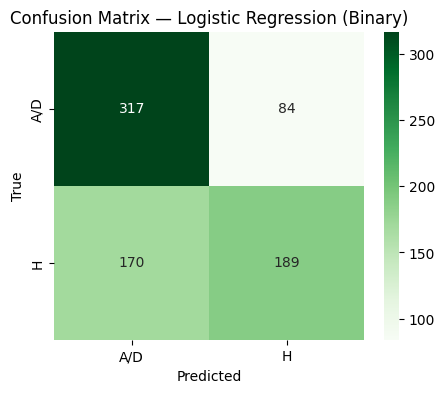

In [180]:
# ============================================
#  LOGISTIC REGRESSION — OPCJA BINARNA
#  H = 1,  A/D = 0
# ============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# ==========================
# 1. Binarne kodowanie celu
# ==========================

df_bin = df.copy()
df_bin["FTR_bin"] = df_bin["FTR"].map({"H":1, "D":0, "A":0})

y_bin = df_bin["FTR_bin"].values
X_bin = df_bin[X_features].copy()


# ==========================
# 2. Podział train / test
# ==========================

split_date = pd.Timestamp("2022-07-01")

train_mask = df_bin["Date"] < split_date
test_mask  = df_bin["Date"] >= split_date

X_train_bin = X_bin.loc[train_mask].reset_index(drop=True)
X_test_bin  = X_bin.loc[test_mask].reset_index(drop=True)
y_train_bin = y_bin[train_mask]
y_test_bin  = y_bin[test_mask]

print("Train:", X_train_bin.shape, " Test:", X_test_bin.shape)


# ==========================
# 3. Pipeline + GridSearch
# ==========================



pipe_bin = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=500, class_weight=None))
])

param_grid_bin = {
    "model__C": [0.01, 0.1, 1, 10, 100]
}

grid_bin = GridSearchCV(
    pipe_bin,
    param_grid_bin,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

print("Trenowanie GridSearchCV (wersja binarna)...")
grid_bin.fit(X_train_bin, y_train_bin)

print("Najlepsze parametry:", grid_bin.best_params_)
print("Najlepszy wynik CV (F1):", grid_bin.best_score_)

best_logreg_bin = grid_bin.best_estimator_


# ==========================
# 4. Wyniki na teście
# ==========================

y_pred_bin = best_logreg_bin.predict(X_test_bin)

acc_bin = accuracy_score(y_test_bin, y_pred_bin)
f1_bin = f1_score(y_test_bin, y_pred_bin)

print("\n=== Logistic Regression (Binary) — TEST ===")
print("Accuracy:", round(acc_bin, 4))
print("F1:", round(f1_bin, 4))

print("\n=== Classification report ===")
print(classification_report(y_test_bin, y_pred_bin, target_names=["NoHomeWin (A/D)", "HomeWin (H)"]))


# ==========================
# 5. Confusion Matrix
# ==========================

cm_bin = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(5,4))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Greens",
            xticklabels=["A/D","H"], yticklabels=["A/D","H"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Logistic Regression (Binary)")
plt.show()
